This notebook uses the LineDetection class to retrieve the coordinates of streaks in images. The purpose of this notebook is to provide an experimentation space to use that class structure and apply it on various images. 

You must have the line_detection.py file in the same folder as this notebook. Additionally, you should have a "Data" folder containing the images that you want to analyze. So far, this code has been tested on 8 images obtained from the following source:

https://epyc.astro.washington.edu/~dinob/dssg/



In [31]:
#Import the module and other libraries
import line_detection

from astropy.io import fits
import astropy.visualization as aviz
%matplotlib inline


In [32]:
#Import your data
'''
I am pasting 8 images that I worked with to write this code. 
But you can use this format to import any image you want
'''

img1 = fits.open('Data/calexp-0941420_07.fits', cache = True)
img2 = fits.open('Data/calexp-0941422_33.fits', cache = True)
img3 = fits.open('Data/calexp-0941424_34.fits', cache = True)
img4 = fits.open('Data/calexp-0941426_16.fits', cache = True)
img5 = fits.open('Data/calexp-0941424_37.fits', cache = True)
img6 = fits.open('Data/STARLINK-1892-20220305200929.fits',cache = True)
img7 = fits.open('Data/STARLINK-1892-N-20220305200959.fits',cache = True)
img8 = fits.open('Data/STARLINK-1905-20220305191929.fits',cache = True)



In [42]:
#Set up your image data
'''
Note:
Please check where the data actually lies in the fits file. You can do that my typing img1.info()
Usually, the image is in the first element i.e. img1[0], but in many cases it can be in the 
2nd element i.e. img1[1]. So before applying the line detection class, make sure your img_data
actually has data

These 2 lines are the code you should change when you want to work with a different image.
'''

img_data = img1[1].data
img_data_copy = img_data.copy()



In [43]:
#Importing the class
detector = line_detection.LineDetection()



#Assigning initial parameters

The class needs certain parameters. You can check the code for the documentation of those parameters. 
But here are those:

        image = the image you want to detect streaks in
        
        trim = Takes True/False. If you want to trim the edges of the image or not
        trim_percent = percentage of edge you want to trim
        
        nstd1_normalize = Reduce outlier pixel intensities beyond these many standard
        deviations in the first cut of processing the image
        nstd2_normalize = Same as above, but for the second cut of image processing
        
        keeppercent = Threshold the image to keep the top x percent of pixel intensity values
        
        threshold = the percentage of diagonal length you want to successfully vote 
                    a line of pixels as a straight line streak
        




Threshold: 579 pixels
Found 20 lines.
original image
<class 'numpy.ndarray'>
(2048, 2048)
edge detected image
<class 'numpy.ndarray'>
(1639, 1639)
Detected line
<class 'numpy.ndarray'>
(2048, 2048, 3)


<AxesSubplot:>

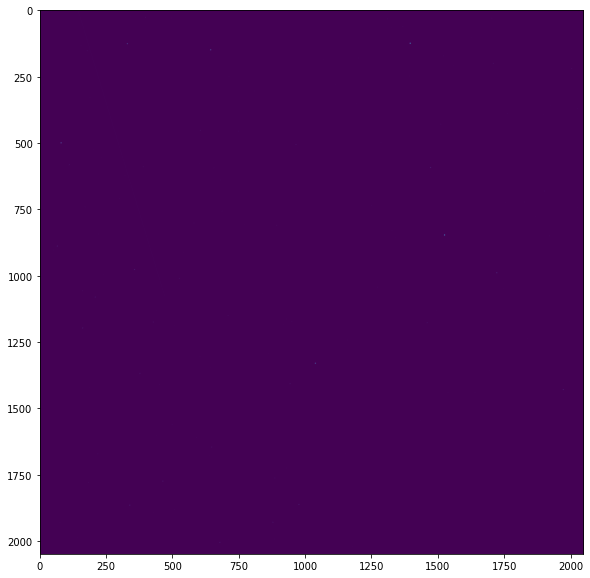

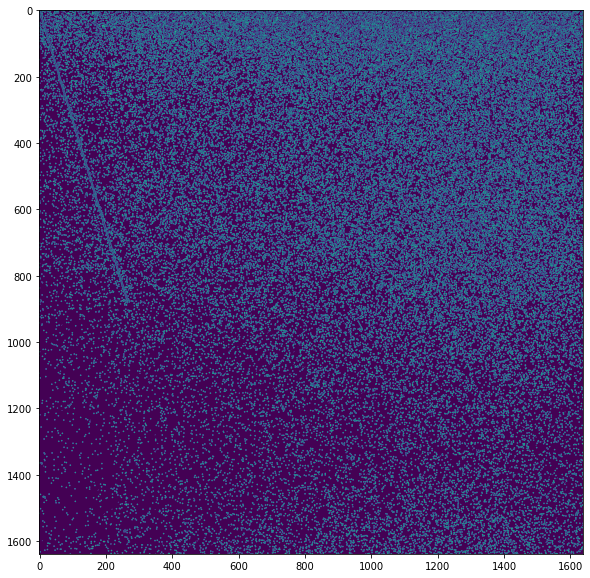

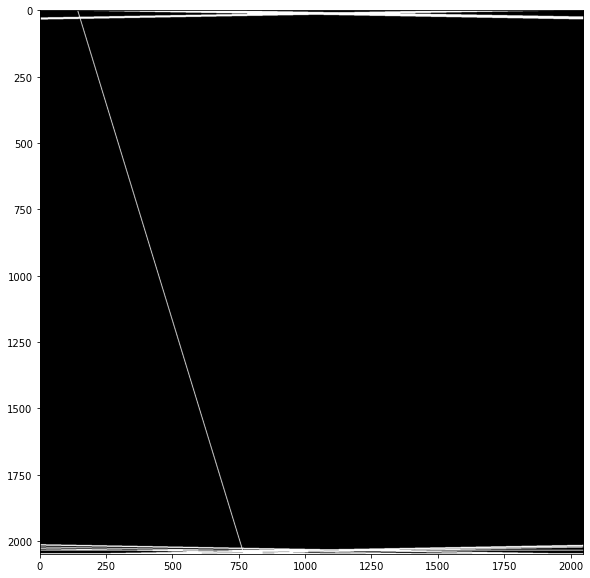

In [44]:
detector.image = img_data_copy
detector.trim = True
detector.trim_percent = 0.9
detector.nstd1_normalize = 5
detector.nstd2_normalize = 3
detector.keeppercent = 0.05
detector.threshold = 0.2

#Conduct the line detection
lined_img,edge,lines = detector.hough_transformation()

#Visualize
print("original image")
detector.show(img_data)

print("edge detected image")
detector.show(edge)

print("Detected line")
detector.show(lined_img)



In [38]:
#List the coordinates of the lines
lines

array([[[2.1380000e+03, 7.8539819e-01]],

       [[2.1400000e+03, 7.8539819e-01]],

       [[2.1350000e+03, 7.8539819e-01]],

       [[2.1430000e+03, 7.8539819e-01]],

       [[2.1330000e+03, 7.8539819e-01]],

       [[2.1450000e+03, 7.8539819e-01]],

       [[2.1310000e+03, 7.8539819e-01]],

       [[2.1470000e+03, 7.8539819e-01]],

       [[2.1280000e+03, 7.8539819e-01]],

       [[2.1500000e+03, 7.8539819e-01]],

       [[2.1260000e+03, 7.6794487e-01]],

       [[2.1230000e+03, 7.6794487e-01]],

       [[2.1520000e+03, 7.8539819e-01]],

       [[2.1510000e+03, 8.0285144e-01]],

       [[2.1640000e+03, 8.0285144e-01]],

       [[2.1620000e+03, 8.0285144e-01]],

       [[2.1540000e+03, 8.0285144e-01]],

       [[2.1670000e+03, 8.0285144e-01]],

       [[2.1600000e+03, 8.0285144e-01]],

       [[2.1580000e+03, 8.0285144e-01]]], dtype=float32)